## Smith-Hutton Problem

We want to solve the following PDE:

\begin{equation}
    u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = 0
\end{equation}

The independen variables (i.e, $x$, $y$) are used as input values for the NN, and the solution (i.e. $\phi(x,y)$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input. The geometry of the problem is as follows:

![sh](pics/sh.png)

In [9]:
import math
import numpy as np 
import matplotlib.pyplot as plt 

import torch
cuda = False
device = torch.device("cuda:0" if torch.cuda.is_available() and cuda else "cpu")
print(device)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

cpu


First we define our PDE and set the values for training.

In [24]:
from nangs import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco

class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None):
        super().__init__(inputs, outputs)
    def computePdeLoss(self, grads, inputs, params): 
        dpdx, dpdy = grads['p']['x'], grads['p']['y']
        x, y = inputs['x'], inputs['y']
        u, v = 2*y*(1-x**2), -2*x*(1-y**2)
        return u*dpdx + v*dpdy

# instanciate pde
pde = MyPDE(inputs=['x', 'y'], outputs=['p'])

# define input values
x = np.linspace(-1,1,40)
y = np.linspace(0,1,20)

pde.setValues({'x': x, 'y': y})

Boundary conditions.

In [25]:
# left and rigth b.c 
ALPHA = 10
x1, x2 = np.array([-1, 1]), np.array([1])
p = np.zeros(2*len(y))
for i in range(2*len(y)): p[i] = 1. - math.tanh(ALPHA)
boco = DirichletBoco(pde.inputs, pde.outputs, {'x': x1, 'y': y}, {'p': p})
pde.addBoco(boco)

# top b.c 
y2 = np.array([1])
p = np.zeros(len(x))
for i in range(len(x)): p[i] = 1. - math.tanh(ALPHA)
boco = DirichletBoco(pde.inputs, pde.outputs, {'x': x, 'y': y2}, {'p': p})
pde.addBoco(boco)

# bottom b.c
y1 = np.array([0])
x1, x2, p1 = [], [], []
for i in range(len(x)): 
    if x[i] < 0:
        x1.append(x[i])
        p1.append(1.+math.tanh(ALPHA*(2*x[i]+1)))
    else:
        x2.append(x[i])
        
x1, p1 = np.array(x1), np.array(p1)
        
boco = DirichletBoco(pde.inputs, pde.outputs, {'x': x1, 'y': y1}, {'p': p1})
pde.addBoco(boco)

# TODO
#boco = NeumannBoco(pde.inputs, pde.outputs, {'x': x2, 'y': y1}, grads={'p': 'y'})
#pde.addBoco(boco)

#pde.bocoSummary()

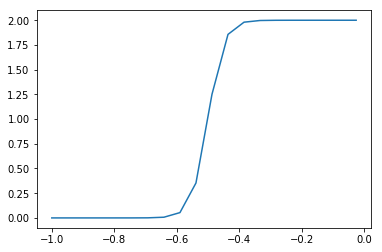

In [26]:
plt.plot(x1,p1)
plt.show()

Now we define a topology for our solution and set the training parameters. Then we can find a solution for our PDE.

In [27]:
# define solution topology
topo = {'layers': 3, 'neurons': 64, 'activations': 'relu'}
pde.buildModel(topo, device)

# set optimization parameters
pde.setSolverParams(lr=0.01,epochs=10, batch_size=10)

In [28]:
# find the solution
pde.solve(device, 'sh_best.pth') 

  0%|          | 0/80 [00:00<?, ?it/s]

Best model, saved !
Epoch: 1, Loss: 0.710159 


  0%|          | 0/80 [00:00<?, ?it/s]

Best model, saved !
Epoch: 2, Loss: 0.268626 


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.300634 


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.319013 


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.408597 


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.381079 


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.378390 


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 8, Loss: 0.387823 


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.353993 


100%|##########| 80/80 [00:06<00:00, 11.62it/s]

Epoch: 10, Loss: 0.378111 


Finally, we can evaluate our solution.

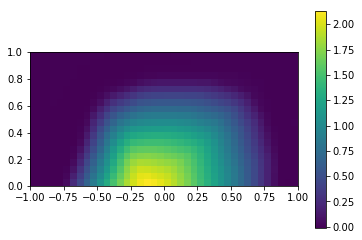

In [40]:
# evaluate the solution
pde.model.load_state_dict(torch.load('sh_best.pth'))
x = np.linspace(-1,1,40)
y = np.linspace(0,1,20)
p = pde.eval({'x': x, 'y': y}, device)
plt.imshow(p.reshape((len(y),len(x))), vmin=p.min(), vmax=p.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

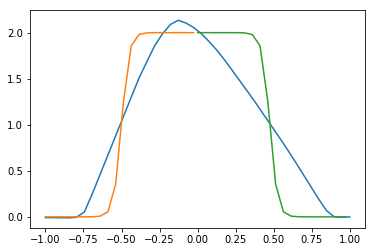

In [47]:
x = np.linspace(-1,1,40)
y = np.array([0])
p = pde.eval({'x': x, 'y': y}, device)
plt.plot(x,p)
plt.plot(x1,p1)
plt.plot(x1+1,np.flip(p1))
plt.show

### Author

Juan Sensio - juansensio03@gmail.com